## <center>Surface classification and automatic detection of supraglacial lakes</center>

During the Arctic summer, surface melting on the Greenland Ice Sheet can produce meltwater near the ice sheet's margins. 
The seasonal meltwater pools in supraglacial lakes in topographic lows on the ice surface and forms a dendritic pattern of meandering streams and rivers that often connects the lakes hydrologically (e.g., [Studinger et al., 2022](https://doi.org/10.5194/tc-16-3649-2022)).

This tutorial demonstrates how natural-color (RGB) imagery can be utilized for ice/water surface classification and lake detection using classic image segmentation methods such as Otsu multi-thresholding and Connected Component Analysis (CCA) on both natural color imagery and the **N**ormalized **D**ifference **W**ater **I**ndex modified for **ice** (NDWI<sub>ice</sub>) derived from RGB images.   

To detect water on the ice sheet, the **N**ormalized **D**ifference **W**ater **I**ndex modified for **ice** (NDWI<sub>ice</sub>) that increases the spectral contrast between liquid water and snow and ice surfaces can be used (e.g., [Yang and Smith, 2013](https://doi.org/10.1109/LGRS.2012.2224316)). [Studinger et al., (2022)](https://doi.org/10.5194/tc-16-3649-2022) used NDWI<sub>ice</sub> for high-resolution surface classification of individual laser footprints from NASA's Airborne Topographic Mapper natural-color imagery. 
The NDWI<sub>ice</sub> of natural-color, three-channel (red, green, blue) images is defined as:


$$
\begin{align}
\textsf{NDWI}_\textsf{ice} = \frac{blue - red} {blue + red} \tag{1}
\end{align}
$$

## Step 1: Calculate NDWI<sub>ice</sub> from natural-color (RGB) imagery
First, load the required Python™ modules and build the image file name:

In [1]:
# load required Python™ modules and build file name for RGB image
import os
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patheffects as fx
from   PIL import Image
from   PIL import ImageEnhance
from   matplotlib.colors import ListedColormap

# set input directory with image file
f_dir_imagery = r".." + os.sep + "data" + os.sep + "imagery"
# set input file name for Jupyter notebook
f_name_rgb = f_dir_imagery + os.sep + "IOCAM0_2019_GR_NASA_20190506-131614.4217.jpg"
x_off = 100
y_off = 100

Import natural-color, three-channel (red, green, blue) image frame using the Pillow fork of the [Python Imaging Library](https://pillow.readthedocs.io/en/stable/). The lakes appear as sapphire-blue features to the eye and in natural color imagery. The image is approximately 480 m wide and 310 m high. 

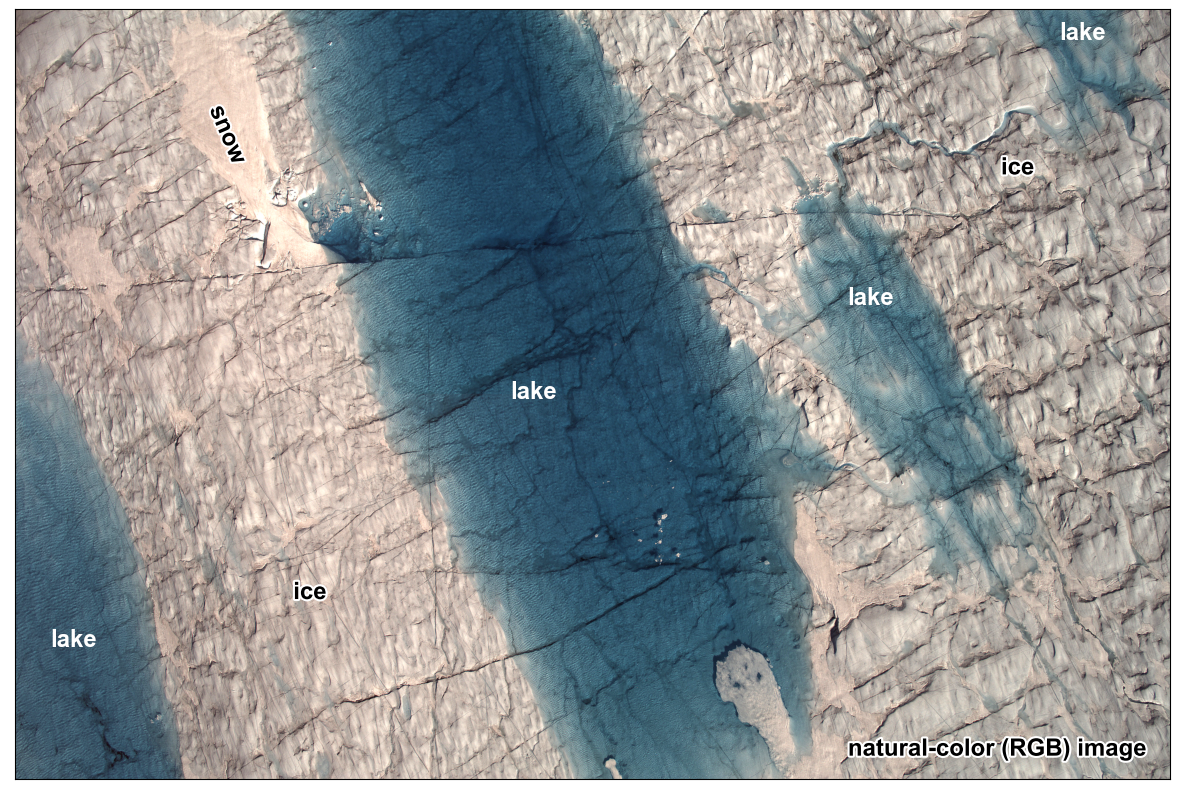

In [2]:
# import natural-color image as type Image, which is needed for OpenCV ImageEnhance
rgb_image = Image.open(f_name_rgb)
img_size  = rgb_image.size # needed for positioning labels in plots below

# enhance brightness for display
enhancer  = ImageEnhance.Brightness(rgb_image)
rgb_adj   = enhancer.enhance(1.2) # brightens the image
# enhance contrast for display
enhancer  = ImageEnhance.Contrast(rgb_adj)
rgb_adj   = enhancer.enhance(1.1) # slightly increases contrast
# enhance sharpness for display
enhancer  = ImageEnhance.Sharpness(rgb_adj)
rgb_adj   = enhancer.enhance(8.5) # slightly increaes sharpness
# save enhanced image for image analysis 
f_name_adj = f_name_rgb.replace(".jpg", "_adj.jpg")
rgb_adj.save(f_name_adj) 

# import original image as type unit8 array needed for image analysis
# Note: in the case of color images, the decoded images will have the channels stored in BGR order. 
image_orig = cv.imread(f_name_rgb,cv.IMREAD_COLOR)   # returns and array of uint8
assert image_orig is not None, "Image file could not be read. Check if path exists. Abort."
rgb_uint8 = cv.cvtColor(image_orig, cv.COLOR_BGR2RGB) # re-arrange channels from BGR to RGB order 

# plot RGB image
plt.rcParams['figure.figsize'] = [15, 10]
mpl.rcParams['font.size'] = 12

fig, (ax1)  = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle1_ax1 = ax1.imshow(rgb_adj)
handle2_txt = ax1.text(1250,2500, "ice", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle3_txt = ax1.text(4250,700,  "ice", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle4_txt = ax1.text(2200,1650, "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle5_txt = ax1.text(250,2700,  "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle6_txt = ax1.text(3625,1250, "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle7_txt = ax1.text(4525,125,  "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle8_txt = ax1.text(900,650,   "snow",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

handle2_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle3_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle8_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle6_txt = ax1.text(img_size[0]-100,img_size[1]-100, "natural-color (RGB) image", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle6_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])

Calculate NDWI<sub>ice</sub> from natural-color image and plot NDWI<sub>ice</sub> :

In [3]:
# calculate NDWI_ice from unadjusted natural-color image
def calc_ndwi(rgb_image):
    """
    SUMMARY:       Calculation of NDWI_ice from three-channel (RGB) natural-color image  
    INPUT:         rgb_image: three-channel (RGB) natural-color image as type Image
    OUTPUT:        2-D array of type float with same size as rgb_image and populated with NDWI_ice values
    SYNTAX:        ndwi = calc_ndwi(rgb_image)
    """
    # first put RGB image into an uint8 array    
    rgb_array = np.array(rgb_image)
    # convert uint8 to float64 for NDWI_ice calculation
    rgb_array = rgb_array.astype(np.float64)
    # red, green, and blue channels are first, second and third dimension of rgb_array
    # NDWI_ice = (blue - red)/(blue + red)
    red  = rgb_array[:,:,0]
    blue = rgb_array[:,:,2]
    ndwi = (blue - red)/(blue + red)    
    return ndwi

# call function and calculate NDWI_ice
ndwi = calc_ndwi(rgb_uint8)

Make color-coded plot of NDWI<sub>ice</sub> over natural-color image with transparency showing snow, ice, and water:

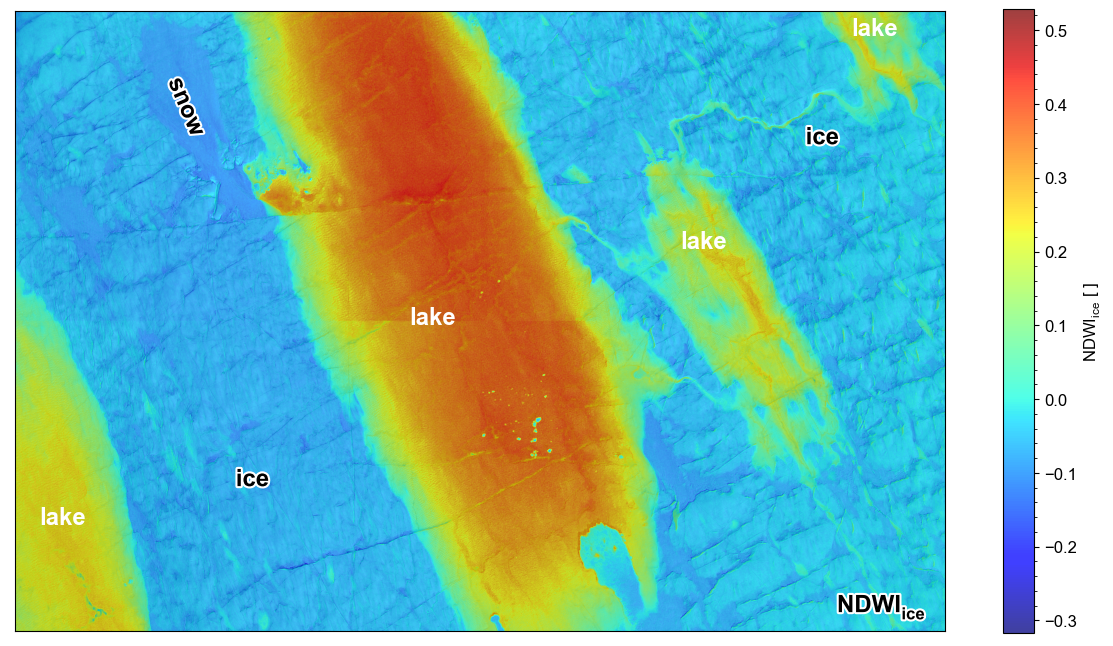

In [4]:
# plot transparent NDWI_ice over adjusted natural-color image

fig2, (ax2) = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
# handle_ax2  = ax2.imshow(rgb_adj) --------------------------------------------
handle_ax2  = ax2.imshow(rgb_adj)
handle_ndwi = ax2.imshow(ndwi, interpolation='bilinear',cmap = plt.cm.jet,alpha = 0.75)
handle2_txt = ax2.text(1250,2500, "ice", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle3_txt = ax2.text(4250,700,  "ice", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle4_txt = ax2.text(2200,1650, "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle5_txt = ax2.text(250,2700,  "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle6_txt = ax2.text(3625,1250, "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle7_txt = ax2.text(4525,125,  "lake",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle8_txt = ax2.text(900,650,   "snow",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

handle2_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle3_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle8_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
handle6_txt = ax2.text(img_size[0]-100,img_size[1]-100, r'$\regularNDWI_{ice}$', fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle6_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])

cbar = fig2.colorbar(handle_ndwi, ax=ax2,location='right',label=r'$\regularNDWI_{ice}$ [ ]', shrink = 0.81) 
cbar.minorticks_on()

## Step 2: Surface classification distinguishing snow & ice from water using Otsu multi-thresholding
A common approach for classifying regions in gray-scale images is [Otsu's method](https://ieeexplore.ieee.org/document/4310076) that applies automatic image thresholding. The code uses the Python™ module [scikit-image](https://scikit-image.org/) which has implemented a modification of [Otsu's](https://ieeexplore.ieee.org/document/4310076) method that can determine multiple thresholds ([Liao, P-S., Chen, T-S. and Chung, P-C., “A fast algorithm for multilevel thresholding”, Journal of Information Science and Engineering 17 (5): 713-727, 2001.](https://doi.org/10.6688/JISE.2001.17.5.1)).

Image segmentation is done by applying multi-thresholding to the NDWI<sub>ice</sub> array.

In [5]:
import skimage as ski

# calculate multiple Otsu thresholds from NDWI_ice separating snow, ice, and water:
otsu_threshold = ski.filters.threshold_multiotsu(ndwi,classes=3, nbins=256)
for i in range(len(otsu_threshold)):
    print(f"Threshold {i+1:d}: {otsu_threshold[i]:5.2f}")


Threshold 1:  0.06
Threshold 2:  0.25


Plot NDWI<sub>ice</sub> histogram with Otsu thresholds separating snow, ice, and water:

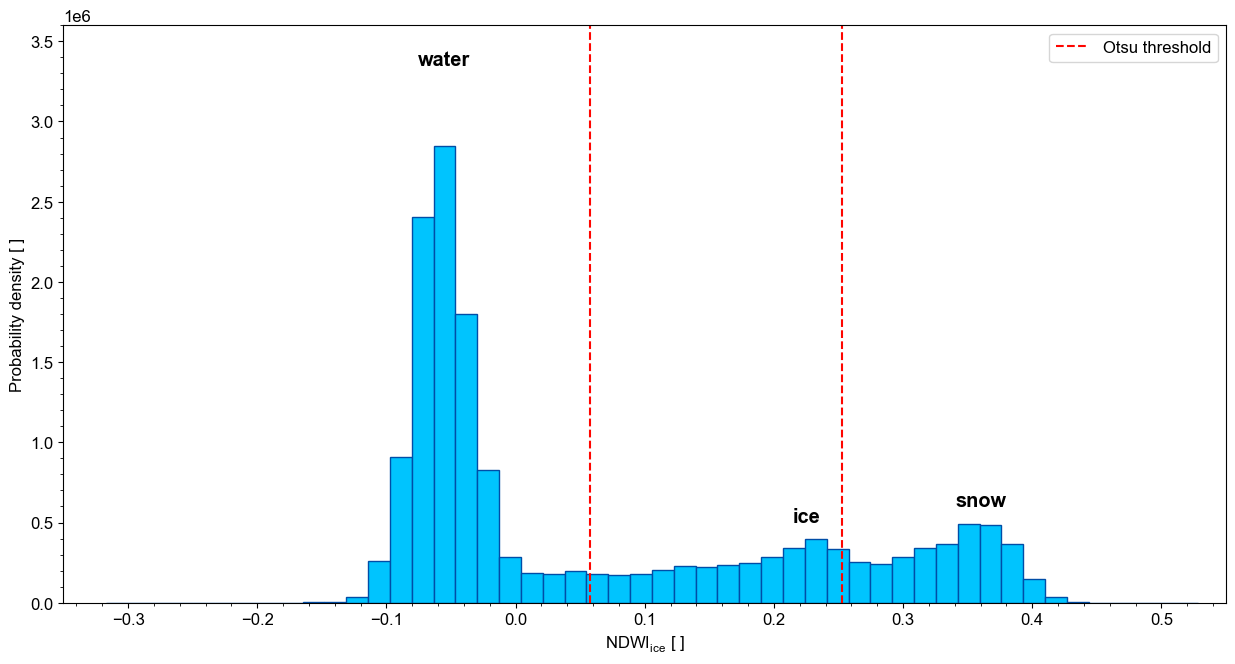

In [6]:
# plot NDWI_ice histogram distribution and the Otsu threshold values separating snow, ice, and water
plt.rcParams['figure.figsize'] = [15, 7.5]

fig3, (ax3) = plt.subplots(1, 1) 
ax3.hist(ndwi.ravel(), bins=50,color = [0/256, 197/256, 255/256], edgecolor = [0/256, 77/256, 168/256])
for k in range(len(otsu_threshold)):
    handle = ax3.axvline(otsu_threshold[k], color = [255/256, 5/256, 0/256], linestyle='--', linewidth=1.5, label='Otsu threshold')
ax3.set_xlabel(r'$\regularNDWI_{ice}$ [ ]')
ax3.set_ylabel('Probability density [ ]')
ax3.text(0.225,500000,"ice" ,   fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
ax3.text(0.360,600000,"snow"  , fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
ax3.text(-0.055,3350000,"water",fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
ax3.minorticks_on()
ax3.set(ylim = (0, 3600000))
ax3.set(xlim = (-0.35, 0.55))
h0 = ax3.legend(handles = [handle], loc='upper right', labelspacing = 0.25)

Create a binary 2-D surface classification mask with 0 (`False`) for snow & ice and 1 (`True`) for water.

In [7]:
# create a binary 2-D surface classification mask separating snow and ice from water using the first Otsu threshold
# as the snow/ice - water threshold
binary_lake_mask = ndwi >= otsu_threshold[0]

Plot transparent surface classification (snow & ice vs. water) based on Otsu (1979) threshold for NDWI<sub>ice</sub> over natural-color image.

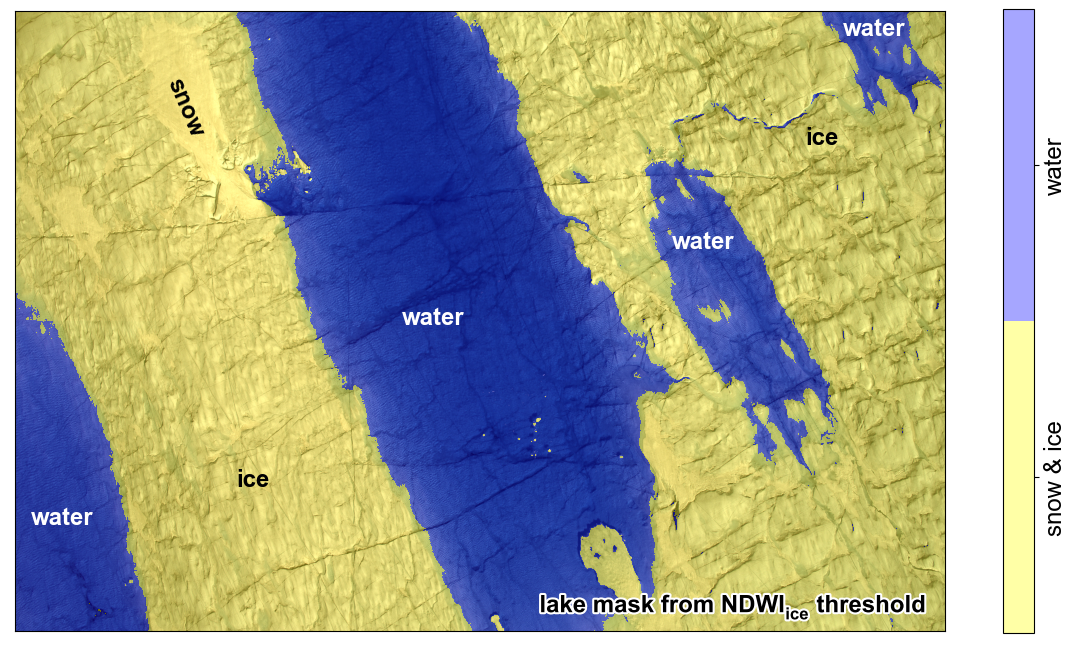

In [8]:
cmap_srf = (mpl.colors.ListedColormap(['yellow', 'blue']))
bounds = [0, 1]
norm = mpl.colors.BoundaryNorm(bounds, cmap_srf.N)
plt.rcParams['figure.figsize'] = [15, 10]
fig4, (ax4) = plt.subplots(1, 1, subplot_kw = {'xticks': [], 'yticks': []}) 
handle_ax4  = ax4.imshow(rgb_adj)
handle_reg  = ax4.imshow(binary_lake_mask, interpolation='bilinear',cmap = cmap_srf,alpha = 0.35)

handle2_txt = ax4.text(1250,2500, "ice", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle3_txt = ax4.text(4250,700,  "ice", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k')
handle4_txt = ax4.text(2200,1650, "water",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle5_txt = ax4.text(250,2700,  "water",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle6_txt = ax4.text(3625,1250, "water",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle7_txt = ax4.text(4525,125,  "water",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'w')
handle8_txt = ax4.text(900,650,   "snow",fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'center', color = 'k', rotation=-67)

handle6_txt = ax4.text(img_size[0]-100,img_size[1]-100, r'lake mask from $\regularNDWI_{ice}$ threshold', fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle6_txt.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])

cbar4 = fig4.colorbar(handle_reg, ax=ax4,location='right', shrink = 0.81) 
cbar4.set_ticks([0.25,0.75])
cbar4.set_ticks(ticks=[0.25,0.75], labels=['snow & ice','water'],fontsize = 'x-large',rotation=90, va='center')
#cbar4.set_tick_params(rotation=45)
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical')

## Step 3: Connected Component Analysis (CCA) 
Determine coherent regions using Connected Component Analysis (CCA) based on Otsu multi-thresholding of NDWI<sub>ice</sub> . 

In [9]:
from skimage.morphology import closing, square, remove_small_objects
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
import matplotlib.patches as mpatches

bw = closing(ndwi >= otsu_threshold[0], square(3)) # array of bool

# label image regions
label_image = label(bw)
image_label_overlay = label2rgb(label_image, image=rgb_uint8, bg_label=0, alpha=0.35, bg_color = None, colors = ['blue','red','green','yellow'])

# find the n largest values in array and populate numpy array with region.area
roi_area = np.empty(0,dtype=float)
moments_central = np.empty(0,dtype=float)

for region in regionprops(label_image): # has 1160 elements... 
    roi_area = np.append(roi_area,region.area)
    moments_central = np.append(moments_central,region.moments_central)

n_highest = 4 # Note: automate selecting number of features using histogram analysis of area size distribution
temp = np.argpartition(-roi_area, n_highest)
result_args = temp[:n_highest] # indices of highest values
temp = np.partition(-roi_area, n_highest)
result = -temp[:n_highest]     # highest values


Plot the results of the Connected Component Analysis (CCA) showing the lakes that were detected:

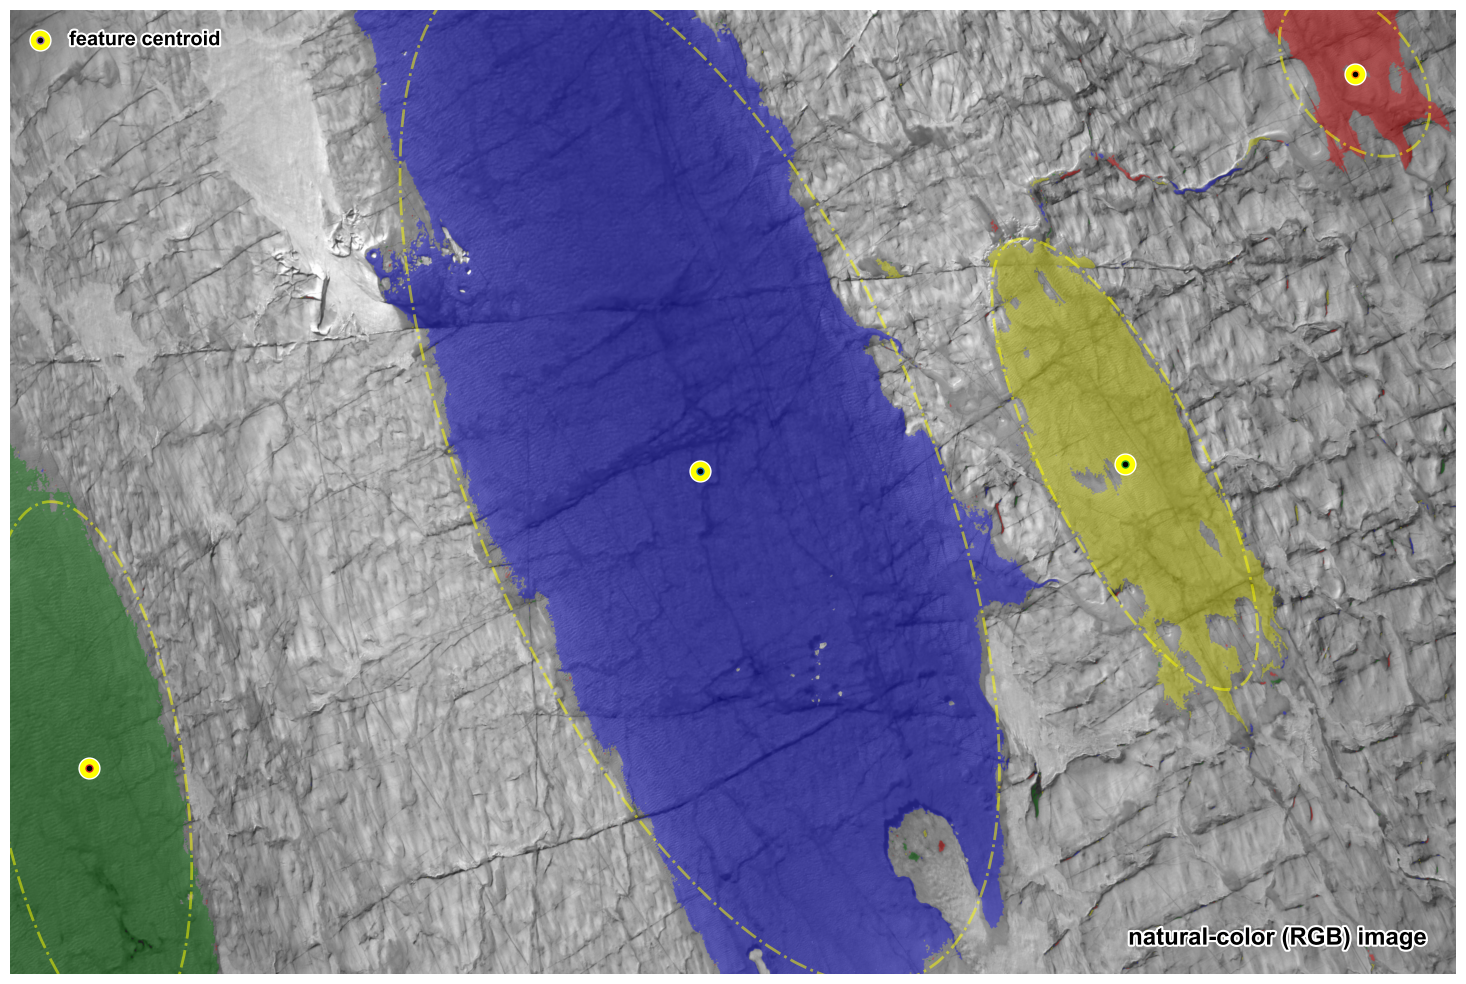

In [10]:
# plot the results of the Connected Component Analysis (CCA)
import math
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # only plot regions with large enough areas
    if region.area >= min(result):
        center = region.centroid
        h99 = ax.plot(center[1],center[0],'o', markersize = 15,color = 'white', lw = 2, label='centroid',markerfacecolor = [255/256, 255/256,   0/256])    
        plt.plot(center[1],center[0],'o', markersize = 5,color = None, label='centroid',markerfacecolor = 'black')    

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= min(result):
        y0, x0 = region.centroid
        orientation = region.orientation
        orientation_deg = np.rad2deg(orientation)
        x1 = x0 + math.cos(orientation) * 0.5 * region.axis_minor_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.axis_minor_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.axis_major_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.axis_major_length
        
        p = ax.add_artist(Ellipse([x0,y0],region.axis_minor_length,region.axis_major_length,angle=-orientation_deg,alpha = 0.5, color=None,fill=None,ec='yellow', lw=2,clip_on = True,linestyle = "-."))
        p.set(clip_on = True)

ax.plot(x_off,y_off,'o', markersize = 15,color = 'white', lw = 2, label='centroid',markerfacecolor = [255/256, 255/256,   0/256])    
plt.plot(x_off,y_off,'o', markersize = 5,color = None, label='centroid',markerfacecolor = 'black') 
handle2_ax1 = ax.text(2*x_off,y_off, "feature centroid", fontsize = 'large',font = 'Arial',fontweight = 'bold', ha = 'left', color = 'k', va="center")
handle2_ax1.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
 
handle2_ax1 = ax.text(img_size[0]-x_off,img_size[1]-y_off, "natural-color (RGB) image", fontsize = 'x-large',font = 'Arial',fontweight = 'bold', ha = 'right', color = 'k')
handle2_ax1.set_path_effects([fx.Stroke(linewidth=3.0, foreground='1.0'),fx.Normal()])
ax.set_axis_off()
plt.tight_layout()
plt.show()


The centroid locations (yellow circles with black dots) of the detected lake segments will be used as **input for the AI-based open-source Segment Anything Model (SAM)** model ([Kirillov et al., 2023](http://arxiv.org/abs/2304.02643)) to refine lake outlines in a separate [Jupyter notebook](https://github.com/mstudinger/ATM-SfM-Bathymetry/blob/main/Jupyter/CAMBOT_v2_lake_detection_using_SAM.ipynb).

## Step 4: Extract largest features and save to DataFrame for input to SAM 
Create DataFrame with only the lakes and parameters of interest and save as pickle file.

In [11]:
# remove small objects
min_area = round(min(result)*0.99) # should return four largest objects 
object_mask = remove_small_objects(bw, min_size=min_area)
label_image_lakes, n = label(object_mask,connectivity=2, return_num=True)
print(f"Extracted {n:d} largest objects with areas ≥ {min_area:d} pixels:\n")

# export to DataFrame
props = regionprops_table(
    label_image_lakes,
    properties=('centroid', 'area','orientation', 'axis_major_length', 'axis_minor_length'),
)

lake_rois = pd.DataFrame(props)

# rename keys
lake_rois = lake_rois.rename(columns={"centroid-0": "centroid_x", "centroid-1": "centroid_y", "area": "area_pixels"}, errors="raise")

# save DataFrame to pickle file
f_name_df = f_name_rgb.replace(".jpg", "_lakes.pkl")
lake_rois.to_pickle(f_name_df)
lake_rois

Extracted 4 largest objects with areas ≥ 160908 pixels:



centroid_x   centroid_y  area_pixels  orientation  axis_major_length  \
0  1560.790360  2334.740873      4368327     0.399696        3716.901565   
1   216.141181  4552.394840       162529     0.676825         634.636152   
2  1536.980647  3774.115493       636283     0.470956        1691.278005   
3  2568.211079   268.090014       826715     0.163424        1824.945920   

   axis_minor_length  
0        1545.156544  
1         409.431562  
2         527.601752  
3         635.312723

**References**
* Kirillov, A. et al., Segment Anything, arXiv, http://arxiv.org/abs/2304.02643, 2023.
* Liao, P-S., Chen, T-S. and Chung, P-C., A fast algorithm for multilevel thresholding, Journal of Information Science and Engineering 17 (5): 713-727, https://doi.org/10.6688/JISE.2001.17.5.1, 2001.
* Otsu, N.: A Threshold Selection Method from Gray-Level Histograms, IEEE Trans. Syst., Man, Cybern., 9, 62–66, https://doi.org/10.1109/TSMC.1979.4310076, 1979.
* Studinger, M., Manizade, S. S., Linkswiler, M. A., and Yungel, J. K.: High-resolution imaging of supraglacial hydrological features on the Greenland Ice Sheet with NASA’s Airborne Topographic Mapper (ATM) instrument suite, The Cryosphere, 16, 3649–3668, https://doi.org/10.5194/tc-16-3649-2022, 2022.
* Yang, K. and Smith, L. C.: Internally drained catchments dominate supraglacial hydrology of the southwest Greenland Ice Sheet: Greenland Internally Drained Catchment, J. Geophys. Res. Earth Surf., 121, 1891–1910, https://doi.org/10.1002/2016JF003927, 2016.